In [1]:
import glob
import os

import pandas as pd

import pgeocode

from pvlib import forecast, clearsky, atmosphere, solarposition
from pvlib.location import Location

%matplotlib notebook

/home/tzech/Repo/pvlib-python/pvlib/forecast.py:19: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


In [2]:
fname_pat = os.path.expanduser("~/data/pv/ausgrid/*.csv")
fnames = glob.glob(fname_pat)

In [3]:
fnames

['/home/tzech/data/pv/ausgrid/2012-2013 Solar home electricity data v2.csv']

In [4]:
data = pd.read_csv(fnames[0], skiprows=1)

In [5]:
data.head()

,Customer,Generator Capacity,Postcode,Consumption Category,date,0:30,1:00,1:30,2:00,2:30,...,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00,Row Quality
0,1,3.78,2076,CL,1/07/2012,1.250,1.250,1.250,1.263,0.131,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.081,NaN
1,1,3.78,2076,GC,1/07/2012,0.855,0.786,0.604,0.544,0.597,...,0.374,0.447,0.549,0.136,0.288,0.181,0.651,0.090,0.068,NaN
2,1,3.78,2076,GG,1/07/2012,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN
3,1,3.78,2076,CL,2/07/2012,1.250,1.250,1.125,0.000,0.925,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.069,NaN
4,1,3.78,2076,GC,2/07/2012,0.309,0.082,0.059,0.097,0.290,...,0.353,0.464,0.229,0.811,0.222,0.306,1.034,0.136,0.067,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268557 entries, 0 to 268556
Data columns (total 54 columns):
Customer                268557 non-null int64
Generator Capacity      268557 non-null float64
Postcode                268557 non-null int64
Consumption Category    268557 non-null object
date                    268557 non-null object
0:30                    268557 non-null float64
1:00                    268557 non-null float64
1:30                    268557 non-null float64
2:00                    268557 non-null float64
2:30                    268557 non-null float64
3:00                    268557 non-null float64
3:30                    268557 non-null float64
4:00                    268557 non-null float64
4:30                    268557 non-null float64
5:00                    268557 non-null float64
5:30                    268557 non-null float64
6:00                    268557 non-null float64
6:30                    268557 non-null float64
7:00                    268557 

In [7]:
data = data.rename({'Postcode': 'postal_code'}, axis=1)
data['postal_code'] = data['postal_code'].astype('str')
postal_codes = data['postal_code'].unique()
postal_codes

array(['2076', '2259', '2263', '2220', '2261', '2230', '2126', '2262',
       '2026', '2218', '2265', '2208', '2229', '2085', '2250', '2283',
       '2305', '2285', '2300', '2093', '2025', '2041', '2303', '2082',
       '2284', '2137', '2048', '2282', '2205', '2224', '2021', '2290',
       '2010', '2135', '2251', '2162', '2227', '2295', '2190', '2029',
       '2204', '2031', '2039', '2087', '2074', '2330', '2291', '2119',
       '2099', '2066', '2100', '2081', '2320', '2134', '2280', '2289',
       '2294', '2159', '2008', '2209', '2203', '2278', '2079', '2228',
       '2044', '2046', '2111', '2077', '2018', '2325', '2324', '2196',
       '2231', '2120', '2260', '2292', '2293', '2086', '2207', '2096',
       '2047', '2233', '2034', '2092', '2264', '2037', '2296', '2286',
       '2200', '2219', '2315', '2211', '2154', '2088', '2198', '2326',
       '2084', '2321', '2281', '2216'], dtype=object)

In [8]:
nomi = pgeocode.Nominatim('au')
geodata = nomi.query_postal_code(postal_codes)

In [9]:
data = data.merge(geodata, on='postal_code')

In [10]:
data.columns

Index(['Customer', 'Generator Capacity', 'postal_code', 'Consumption Category',
       'date', '0:30', '1:00', '1:30', '2:00', '2:30', '3:00', '3:30', '4:00',
       '4:30', '5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00', '8:30',
       '9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00', '12:30',
       '13:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30',
       '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30',
       '21:00', '21:30', '22:00', '22:30', '23:00', '23:30', '0:00',
       'Row Quality', 'country code', 'place_name', 'state_name', 'state_code',
       'county_name', 'county_code', 'community_name', 'community_code',
       'latitude', 'longitude', 'accuracy'],
      dtype='object')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268557 entries, 0 to 268556
Data columns (total 65 columns):
Customer                268557 non-null int64
Generator Capacity      268557 non-null float64
postal_code             268557 non-null object
Consumption Category    268557 non-null object
date                    268557 non-null object
0:30                    268557 non-null float64
1:00                    268557 non-null float64
1:30                    268557 non-null float64
2:00                    268557 non-null float64
2:30                    268557 non-null float64
3:00                    268557 non-null float64
3:30                    268557 non-null float64
4:00                    268557 non-null float64
4:30                    268557 non-null float64
5:00                    268557 non-null float64
5:30                    268557 non-null float64
6:00                    268557 non-null float64
6:30                    268557 non-null float64
7:00                    268557

In [12]:
customer0 = data['Customer'].unique()[0]
sel_cus_gen = data['Customer'] == customer0
sel_cus_gen &= data['Consumption Category'] == 'GG'
df = data.loc[sel_cus_gen]

In [13]:
df.Customer.unique(), df.postal_code.unique(), df['Consumption Category'].unique()

(array([1]), array(['2076'], dtype=object), array(['GG'], dtype=object))

<IPython.core.display.Javascript object>


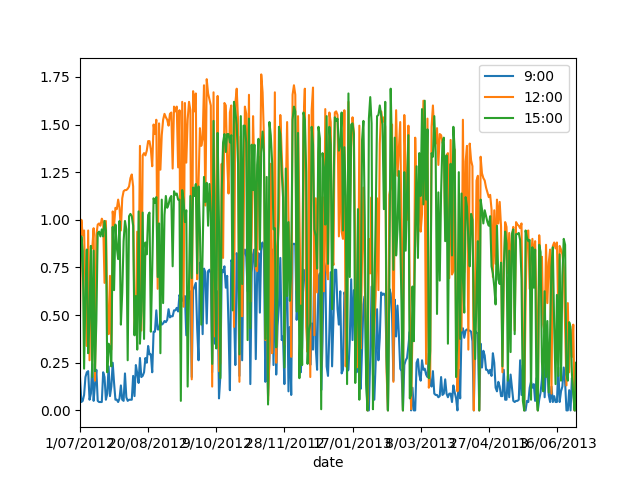

In [17]:
df[['date', '9:00', '12:00', '15:00']].set_index('date').plot()

In [26]:
ts1200 = df[['date', '12:00']].set_index('date')
max_delay = 9
peEn_cols = []
for d in range(1, max_delay+1):
    d_str = '-{0}d'.format(d)
    peEn_cols.append(d_str)
    ts1200[d_str] = ts1200.shift(d)['12:00']

In [38]:
ts1200.apply?

<IPython.core.display.Javascript object>


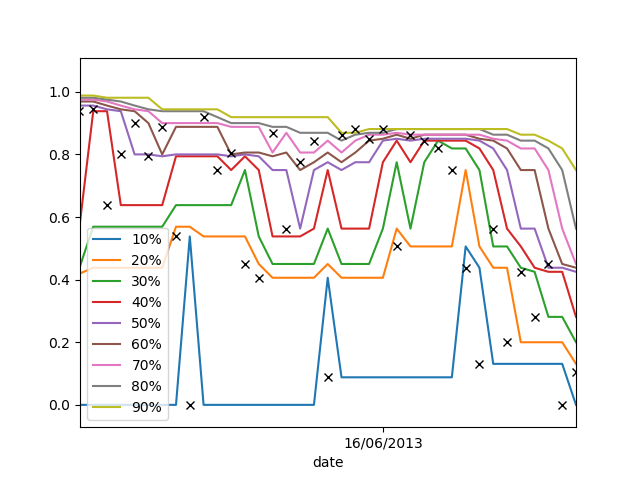

In [52]:
peEn = ts1200[peEn_cols].apply(lambda s: s.sort_values().values, axis=1, result_type='expand')
peEn.columns = ['{}%'.format(x) for x in range(10, 100, 10)]
peEn.plot()
ts1200['12:00'].plot(style='kx')